In [1]:
from PIL import Image, ImageOps
import numpy as np
from einops import rearrange
from src.utils.mask_v2 import Maskerv2

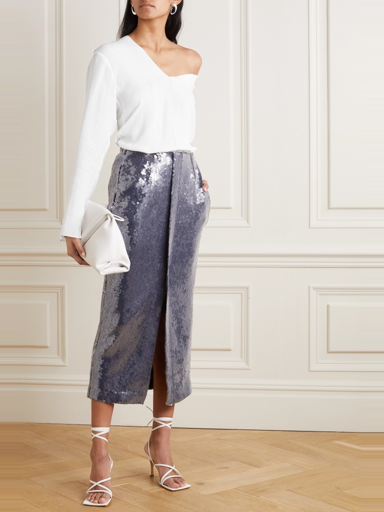

In [89]:
# h, w = (384, 192)
# h, w = (1024, 768)
h, w = (512, 384)
# h, w = (800, 600)
BASE_DATA_PATH= '/mnt/f/hosjiu/data/dresscode/' # You need to point your data root path here.
CATEGORY = 'upper_body'
img = Image.open(f'{BASE_DATA_PATH}/{CATEGORY}/images/011540_0.jpg')
# img = Image.open('../assets/red_dress_girl.jpg')
img = ImageOps.fit(img, size=(w, h))
img

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


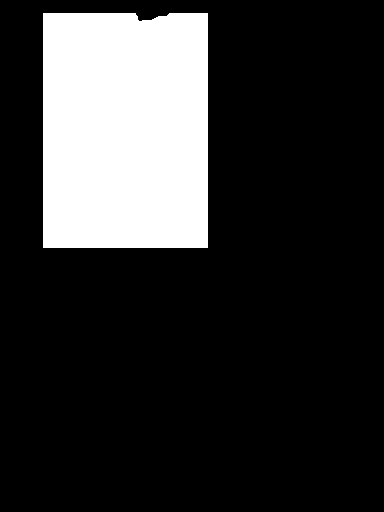

In [90]:
masker = Maskerv2()
mask, body_parse = masker.create_mask(img, category='upper_body', return_body_parse=True)
mask

### Random dilated mask

In [91]:
import cv2
import cv2 as cv
import numpy as np

mask_arr = np.array(mask)
mask_arr = cv2.erode(mask_arr, np.ones((3, 3), np.uint8), iterations=1)
contours, _ = cv2.findContours(mask_arr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours

(array([[[ 44,  14]],
 
        [[ 44, 246]],
 
        [[206, 246]],
 
        [[206,  14]],
 
        [[170,  14]],
 
        [[167,  17]],
 
        [[159,  17]],
 
        [[158,  18]],
 
        [[157,  18]],
 
        [[156,  19]],
 
        [[155,  19]],
 
        [[154,  20]],
 
        [[153,  20]],
 
        [[152,  21]],
 
        [[143,  21]],
 
        [[142,  22]],
 
        [[138,  22]],
 
        [[136,  20]],
 
        [[136,  17]],
 
        [[134,  15]],
 
        [[134,  14]]], dtype=int32),)

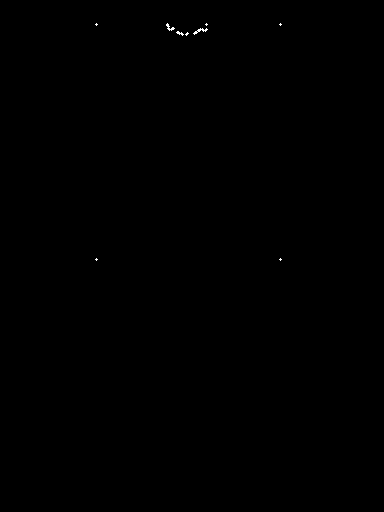

In [83]:
hull = cv2.convexHull(contours[0])
contour_arr = cv2.drawContours(np.zeros_like(mask), contours[0], -1, (255, 0, 0), 2)
Image.fromarray(contour_arr)

In [84]:
hull = np.squeeze(hull)
hull

array([[280,  24],
       [280, 259],
       [ 96, 259],
       [ 96,  24]], dtype=int32)

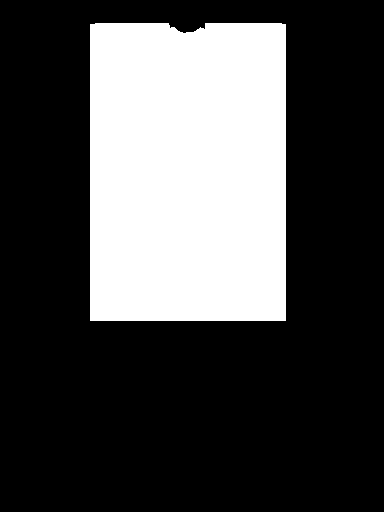

In [86]:
""" Main Implementation """
import random

delta_x = random.uniform(0, 0.1)
delta_y = random.uniform(0, 0.3)
mask_width = hull[0][0] - hull[3][0]
mask_height = hull[1][1] - hull[0][1]
new_x_left = int(hull[3][0] - delta_x * mask_width)
new_x_right = int(hull[0][0] + delta_x * mask_width)
new_y = int(hull[1][1] + delta_y * mask_height)

new_x_left = max(0, new_x_left)
new_x_right = min(new_x_right, mask.size[0])
new_y = min(new_y, mask.size[1])

new_mask = cv.rectangle(np.array(mask), (new_x_left, hull[3][1]), (hull[2][0], hull[2][1]), (255, 255, 255), cv.FILLED)
new_mask = cv.rectangle(new_mask, (hull[0][0], hull[0][1]), (new_x_right, hull[1][1]), (255, 255, 255), cv.FILLED)
new_mask = cv.rectangle(new_mask, (new_x_left, hull[2][1]), (new_x_right, new_y), (255, 255, 255), cv.FILLED)

Image.fromarray(new_mask)

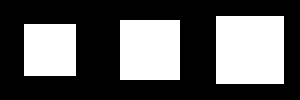

In [264]:
import cv2
import numpy as np
from diffusers.utils import make_image_grid

# Create a simple binary image (white square on black background)
image = np.zeros((100, 100), np.uint8)
image[30:70, 30:70] = 255

# Define a kernel (structuring element)
kernel = np.ones((5, 5), np.uint8)

# Dilate the image with different iterations
dilated_1 = cv2.dilate(image, kernel, iterations=3)
dilated_2 = cv2.dilate(image, kernel, iterations=5)
dilated_3 = cv2.dilate(image, kernel, iterations=7)

make_image_grid(list(map(Image.fromarray, [dilated_1, dilated_2, dilated_3])), 1, 3)

# Display the results (you'll need a way to display images, e.g., using matplotlib)
# ...

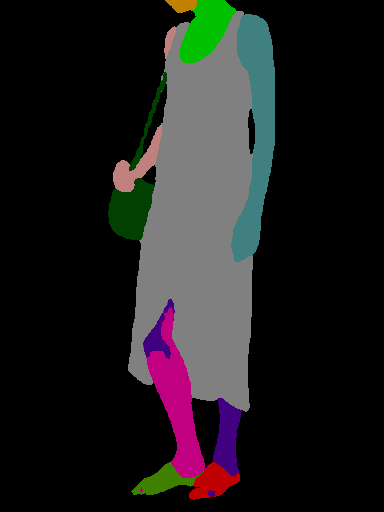

In [60]:
body_parse

In [61]:
13 in np.array(body_parse)

True

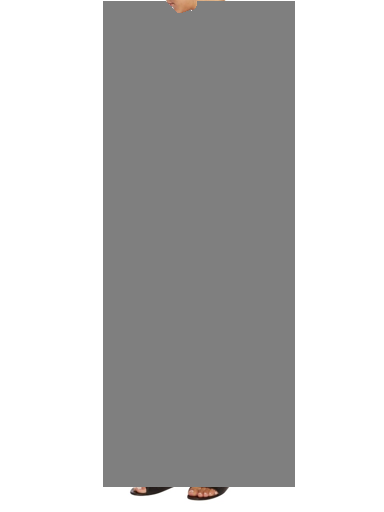

In [62]:
mask_np = np.array(mask)
mask_np = np.stack([mask_np] * 3)
mask_np = rearrange(mask_np, 'c h w -> h w c')
img_np = np.array(img)
out = np.where(mask_np, np.ones_like(mask_np) * 127, img_np)
Image.fromarray(out)

In [63]:
# mask = Image.open('../datasets/vitonhd/train/agnostic-mask-v2/00113_00.jpg')

# mask_np = np.array(mask)
# mask_np = np.stack([mask_np] * 3)
# mask_np = rearrange(mask_np, 'c h w -> h w c')
# img_np = np.array(img)
# masked_img_np = np.where(mask_np, np.ones_like(mask_np) * 127, img_np)
# Image.fromarray(masked_img_np)

In [64]:
from diffusers.utils import make_image_grid

make_image_grid([mask, Image.fromarray(out), img], 1, 3).save('/mnt/f/hosjiu/test.jpg')